## Block Number Interpolation

(currently using disambiguous v02)

1. **Sequence Restriction**

This notebook interpolates block numbers by filling in if unknown dwellings are in between known dwellings of the same
    1. block number
    2. block number and distance sequence
    3. block number, distance sequence, and enum_dist
    4. block number, distance sequence, enum_dist, and other sequence

2. **Max Distance Restriction** and **In between number of dwellings**

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import disambiguation_analysis as da

# Setup

* Read in datasets and set column names

In [7]:
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v02.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_mn_20200918.csv") #For calculating centroids
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_union_20201202.csv")

filled_1850['CENSUS_PAGENUM'] = filled_1850['CENSUS_PAGENUM']//10

In [8]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"

### CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM - CENSUS_ENUMERATOR_NUM - CENSUS_ENUMERATOR_DATE is a minimal key for all wards

* We have previously used only CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM for ward 10, is a minimal key for ward 10 specificaly
* **Need more specificity when merging this into all dwellings. Otherwise, 1 dwelling could be assigned to 2 different enumeration sequences**

In [9]:
print('KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM is a minimal key in')
unique_wards = []
for w in enumerators['CENSUS_WARD_NUM'].unique():
    tempw = enumerators.loc[enumerators['CENSUS_WARD_NUM'] == w]
    if tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM']].shape[0] == tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM']].drop_duplicates().shape[0]:
        print('ward ', w)
        unique_wards.append(w)

KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM is a minimal key in
ward  1
ward  2
ward  3
ward  4
ward  5
ward  6
ward  10
ward  13
ward  14
ward  15
ward  19


In [10]:
print('KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM - CENSUS_ENUMERATOR_NUM is a minimal key in ')
for w in enumerators['CENSUS_WARD_NUM'].unique():
    tempw = enumerators.loc[enumerators['CENSUS_WARD_NUM'] == w]
    if tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM', 'CENSUS_ENUMERATOR_NUM']].shape[0] == tempw[['CENSUS_PAGENO_HOUSEHOLD', 'CENSUS_WARD_NUM', 'CENSUS_ENUMERATOR_NUM', 'CENSUS_ENUMERATOR_DATE']].drop_duplicates().shape[0]:
        print('ward ', w)

KEY: CENSUS_PAGENO_HOUSEHOLD - CENSUS_WARD_NUM - CENSUS_ENUMERATOR_NUM is a minimal key in 
ward  1
ward  2
ward  3
ward  4
ward  5
ward  6
ward  7
ward  8
ward  9
ward  10
ward  11
ward  12
ward  13
ward  14
ward  15
ward  16
ward  17
ward  18
ward  19


## Page number is not unique within wards

* enumerate new page number so that it is unique within a ward

In [11]:
# to_unique_pagenum_list = []
# for w in enumerators2[ward_col].unique():
#     temp = enumerators2.loc[enumerators2[ward_col] == w].copy()
#     temp.reset_index(inplace=True)
    
#     start_page = temp.loc[0, 'CENSUS_PAGENNO']
#     end_page = temp.shape[0]
#     unique_CENSUS_PAGENNO = range(start_page, start_page+end_page)
#     temp['CENSUS_PAGENNO_unique'] = unique_CENSUS_PAGENNO
#     temp[ward_col] = w
#     to_unique_pagenum_list.append(temp[[ward_col, 'CENSUS_PAGENNO', 'CENSUS_PAGENNO' + '_unique']])
# to_unique_pagenum = pd.concat(to_unique_pagenum_list, axis=0)

In [12]:
# print(enumerators.shape)
# print(enumerators2.shape)

In [13]:
# print('KEY: CENSUS_PAGENO - CENSUS_WARD_NUM is a minimal key in')
# unique_wards = []
# for w in enumerators2['CENSUS_WARD_NUM'].unique():
#     tempw = enumerators2.loc[enumerators2['CENSUS_PAGENNO_uniquewithinward'] == w]
#     if tempw[['CENSUS_PAGENNO_uniquewithinward', 'CENSUS_WARD_NUM']].shape[0] == tempw[['CENSUS_PAGENNO_uniquewithinward', 'CENSUS_WARD_NUM']].drop_duplicates().shape[0]:
#         print('ward ', w)
#         unique_wards.append(w)

## Append page sequence id for mergering with enum data

In [14]:
def append_page_sequence_id(df, ward_col, page_col):
    temp = df.copy()
    temp['prev_page'] = temp.groupby(ward_col)[page_col].shift(1)
    temp['prev_ward'] = temp[ward_col].shift(1)
    temp['page_sequence_id'] = np.where((temp['prev_ward'] != temp[ward_col]) |
                                        (temp['prev_page'] > temp[page_col]), 
                                        temp[page_col].index, np.nan)
    temp['page_sequence_id'] = temp.groupby(ward_col)['page_sequence_id'].ffill()

    df_list = []
    for w in df[ward_col].unique():
        temp_df = temp.loc[temp[ward_col] == w]
        page_id = temp_df['page_sequence_id'].unique()
        page_id.sort()
        enum_list = []
        for i in range(len(page_id)):
            enum_list.append(i)
        df_list.append(pd.DataFrame({ward_col: w, 'page_sequence_id': page_id, 'new_page_sequence_id': enum_list}))
    to_new_page_id = pd.concat(df_list, axis=0)
    temp = temp.merge(to_new_page_id, on=[ward_col, 'page_sequence_id'], how='left')
    temp.drop(columns=['prev_page', 'prev_ward', 'page_sequence_id'], inplace=True)
    temp.rename(columns={'new_page_sequence_id': 'page_sequence_id'}, inplace=True)
    return temp

In [15]:
filled_1850_2 = append_page_sequence_id(filled_1850, ward_col, pagenum)

In [16]:
enumerators_2 = append_page_sequence_id(enumerators, ward_col, 'CENSUS_PAGENNO')

In [17]:
print(enumerators.shape)
print(enumerators_2.shape)

(12350, 9)
(12350, 10)


In [ ]:
enumerators_2.loc[enumerators_2[ward_col] == 8].groupby('page_sequence_id', as_index=False).first()[[ward_col, 'CENSUS_PAGENNO']]

In [ ]:
filled_1850_2.columns

In [ ]:
filled_1850_2.loc[filled_1850_2[ward_col] == 8].groupby('page_sequence_id', as_index=False).first()[[ward_col, 'CENSUS_PAGENUM']]

In [18]:
filled_ch = filled_1850_2[[ward_col, 'page_sequence_id']].groupby(ward_col)['page_sequence_id'].agg('nunique')
enum_ch = enumerators_2[[ward_col, 'page_sequence_id']].groupby(ward_col)['page_sequence_id'].agg('nunique')

In [19]:
filled_ch != enum_ch

CENSUS_WARD_NUM
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: page_sequence_id, dtype: bool

In [ ]:
filled_ch[[10]]

In [ ]:
enum_ch[[10]]

In [ ]:
enumerators_2.loc[enumerators_2[ward_col] == 18].groupby([ward_col, 'page_sequence_id'], as_index=False).first()[[ward_col, 'CENSUS_PAGENNO', 'page_sequence_id']]

In [ ]:
filled_1850_2.loc[filled_1850_2[ward_col] == 18].groupby([ward_col, 'page_sequence_id'], as_index=False).first()[[ward_col, 'CENSUS_PAGENUM', 'page_sequence_id']]

In [ ]:
enumerators_2.loc[enumerators_2[ward_col] == 8].groupby([ward_col, 'page_sequence_id'], as_index=False).first()[[ward_col, 'CENSUS_PAGENNO', 'page_sequence_id']]

In [ ]:
filled_1850_2.loc[filled_1850_2[ward_col] == 8].groupby([ward_col, 'page_sequence_id'], as_index=False).first()[[ward_col, 'CENSUS_PAGENUM', 'page_sequence_id']]

In [ ]:
3882
enumerators_2.iloc[3455:3460][[ward_col, 'CENSUS_PAGENNO', 'page_sequence_id']]

In [ ]:
3882
enumerators_2.iloc[3350:3355][[ward_col, 'CENSUS_PAGENNO', 'page_sequence_id']]

In [ ]:
pd.set_option('max_rows', 100)
temp[[ward_col, 'CENSUS_PAGENUM_shorten', 'page_sequence_id']].iloc[123020:123025]

In [ ]:
temp.loc[temp['page_sequence_id'] > 0][[ward_col, 'CENSUS_PAGENUM_shorten', 'page_sequence_id']]

In [ ]:
enumerators_2.columns

In [ ]:
enumerators_2['CENSUS_PAGENNO']

In [22]:
# filled_1850_new_pagenum = filled_1850_2.merge(dwelling_to_new_pagenum, on =[ward_col, dwelling_col])
census_enumerators = filled_1850_2.merge(enumerators_2,  how = "left", 
                                                   left_on= [ward_col, 'CENSUS_PAGENUM', 'page_sequence_id'], 
                                                   right_on = ["CENSUS_WARD_NUM", "CENSUS_PAGENNO", 'page_sequence_id'])
census_enumerators.drop(columns=['CENSUS_PAGENNO', 'CENSUS_PAGENO_HOUSEHOLD', 'Notes'], inplace=True)

In [23]:
##check if unique. Must be True
print(filled_1850_2.shape)
print(census_enumerators.shape)

census_enumerators.shape[0] == filled_1850_2.shape[0]

(515630, 31)
(515630, 36)


True

## Ward 12 has no block number

In [ ]:
filled_1850_temp = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v02.csv")
filled_1850_temp.loc[filled_1850_temp[ward_col] == 12][block_col].unique()

## Generate sequences

In [24]:
census_enum_seq = CensusData(census_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                 fixed = True, distance = True, d=0.1)

d:  0.1


In [25]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[block_col])

## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
## dwellings_sequence => known dwellings
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        block_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

In [26]:
all_dwellings_1 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_2 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id'], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_3 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id', 'enum_dist_id'], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_4 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id', 
                                                                       'enum_dist_id', 'fixed_seq',
                                                                      'dwelling_seq_id'], ward_col = ward_col, dwelling_col = dwelling_col)

In [27]:
## check if sequence_id or enum_dist_id is NaN when the other is not. Should not happen
temp = all_dwellings_3[[ward_col, block_col, dwelling_col, 'sequence_id', 'enum_dist_id', pagenum]]
temp.loc[(~temp['sequence_id'].isnull()) & (temp['enum_dist_id'].isnull())]

,CENSUS_WARD_NUM,CD_BLOCK_NUM,dwelling_id,sequence_id,enum_dist_id,CENSUS_PAGENUM
17840,10,mn1850_10_73.9958_40.7154,1977,17849.0,NaN,559
17845,10,mn1850_10_73.9958_40.7154,1982,17849.0,NaN,561
17846,10,mn1850_10_73.9958_40.7154,1983,17849.0,NaN,561
17848,10,mn1850_10_73.9958_40.7154,1985,17849.0,NaN,561
17849,10,mn1850_10_73.9958_40.7154,1986,17849.0,NaN,561
17850,10,mn1850_10_73.9932_40.7147,1987,17850.0,NaN,561
17852,10,mn1850_10_73.9949_40.7151,1989,17857.0,NaN,562
17854,10,mn1850_10_73.9949_40.7151,1991,17857.0,NaN,562
17855,10,mn1850_10_73.9949_40.7151,1992,17857.0,NaN,562
17856,10,mn1850_10_73.9949_40.7151,1993,17857.0,NaN,563


## Result

In [28]:
total_num_dwellings = census_all_dwellings.groupby([ward_col, dwelling_col]).ngroups
known_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups

all_dwelling_list = [all_dwellings_1,all_dwellings_2, all_dwellings_3, all_dwellings_4]
in_between_num = 15
num_assigned_dwelling = []

print('\nTotal number of Dwellings: ',total_num_dwellings, '\n')
for all_dwelling_x in all_dwelling_list:
    ##interpolated portion
    total_assigned_dwellings = all_dwelling_x.loc[~all_dwelling_x[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups
#     total_assigned_dwellings = with_block_num_dwellings.shape[0]
    num_assigned_dwelling.append(round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5))
    
    print("Maximum of {} dwellings between".format(str(in_between_num)))
    print("Number of dwellings that would be assigned a block:", total_assigned_dwellings - known_num_dwellings)
    print("Proportion increase dwellings assigned a block:", round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5), "\n")



Total number of Dwellings:  38560 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 6086
Proportion increase dwellings assigned a block: 0.15783 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 5991
Proportion increase dwellings assigned a block: 0.15537 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 4830
Proportion increase dwellings assigned a block: 0.12526 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 4358
Proportion increase dwellings assigned a block: 0.11302 



Text(0.5, 1.0, 'Increase Proportion of Dwellings assigned a block')

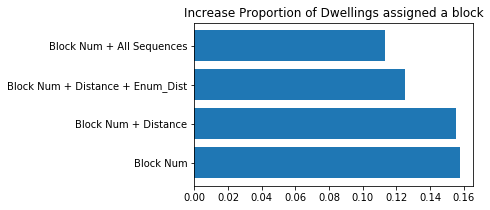

In [29]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.barh(['Block Num', 'Block Num + Distance', 'Block Num + Distance + Enum_Dist', 'Block Num + All Sequences'], num_assigned_dwelling)
# ax.scatter(num_between, num_assigned_dwelling)
ax.set_title("Increase Proportion of Dwellings assigned a block")

## Proportion increased by wards

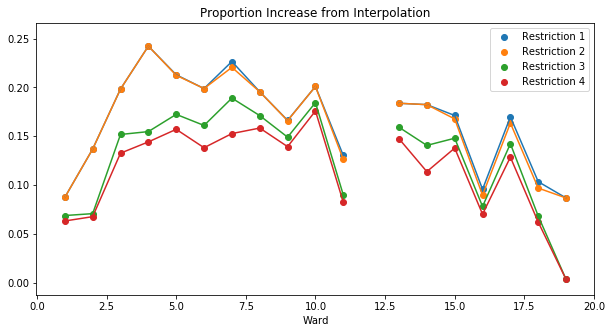

In [30]:
total_num_dwellings = census_all_dwellings.groupby(ward_col)[dwelling_col].agg('nunique')
known_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[block_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')

fig, ax = plt.subplots(1,1, figsize=(10, 5))
for i in range(4): 
    
    assigned_num_dwellings = all_dwelling_list[i].loc[~all_dwelling_list[i][block_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')
    additional_assigned_dwellings = assigned_num_dwellings - known_num_dwellings
    increase_proportion = additional_assigned_dwellings/total_num_dwellings
    
    ax.scatter(increase_proportion.index, increase_proportion.values, label=f'Restriction {i+1}')
    ax.plot(increase_proportion.index, increase_proportion.values)
    
ax.set_title(f'Proportion Increase from Interpolation')
ax.set_xlabel('Ward')
ax.legend()

## Take a look at where they differ

### 1 vs 2

In [31]:
(all_dwellings_1[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1)).sum()

95

In [32]:
np.where(all_dwellings_1[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1))

(array([ 4691,  7282,  7283,  7595,  7596,  7597,  7598,  7998,  9128,
         9129,  9158,  9159,  9160,  9161,  9162,  9506, 15087, 17955,
        17956, 18083, 18084, 18085, 18086, 19704, 19705, 19706, 19879,
        25627, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 28394,
        28395, 28396, 28397, 28398, 28696, 28697, 28698, 28699, 28700,
        29048, 29049, 29357, 29358, 29359, 29360, 29361, 29362, 29363,
        29364, 29365, 29366, 29367, 30501, 31222, 32096, 32345, 32346,
        32347, 32348, 32349, 32350, 32351, 32352, 32353, 32354, 32355,
        32356, 32357, 32358, 32359, 32360, 34549, 34550, 34551, 34840,
        34841, 34842, 34843, 34844, 34845, 34846, 34847, 34848, 34849,
        34850, 34851, 34865, 34866, 34867]),)

In [33]:
## sample of where they are different
all_dwellings_2[[ward_col, 'dwelling_id', block_col, 'sequence_id']].iloc[4685:4695]

,CENSUS_WARD_NUM,dwelling_id,CD_BLOCK_NUM,sequence_id
4685,5,996,mn1850_05_74.0096_40.7210,4688.0
4686,5,997,NaN,NaN
4687,5,998,NaN,NaN
4688,5,999,mn1850_05_74.0093_40.7203,4688.0
4689,5,1000,mn1850_05_74.0062_40.7210,4690.0
4690,5,1001,mn1850_05_74.0072_40.7222,4690.0
4691,5,1002,NaN,NaN
4692,5,1003,mn1850_05_74.0072_40.7222,4694.0
4693,5,1004,mn1850_05_74.0087_40.7216,4694.0
4694,5,1005,mn1850_05_74.0094_40.7217,4694.0


In [37]:
## sample of where they are different
all_dwellings_2[[ward_col, 'dwelling_id', block_col, 'sequence_id']].iloc[25645:25660]

,CENSUS_WARD_NUM,dwelling_id,CD_BLOCK_NUM,sequence_id
25645,15,773,NaN,NaN
25646,15,774,NaN,NaN
25647,15,775,NaN,NaN
25648,15,776,mn1850_15_73.9968_40.7344,25649.0
25649,15,777,mn1850_15_73.9968_40.7344,25649.0
25650,15,778,NaN,NaN
25651,15,779,NaN,NaN
25652,15,780,NaN,NaN
25653,15,781,NaN,NaN
25654,15,782,NaN,NaN


### 2 vs 3

In [38]:
(all_dwellings_3[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1)).sum()

1161

In [44]:
np.where(all_dwellings_3[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1))[0][100:200]

array([2579, 2580, 2581, 2582, 2583, 2584, 2585, 2612, 2613, 2614, 2615,
       2616, 2660, 2661, 2673, 2686, 2746, 2775, 2776, 2777, 2778, 2779,
       2780, 2798, 2825, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2849,
       2850, 2851, 2852, 2853, 3087, 3150, 3151, 3152, 3155, 3205, 3206,
       3207, 3238, 3239, 3243, 3249, 3253, 3303, 3304, 3370, 3371, 3372,
       3413, 3414, 3415, 3416, 3439, 3440, 3441, 3448, 3449, 3450, 3467,
       3468, 3469, 3473, 3481, 3482, 3502, 3503, 3504, 3538, 3539, 3540,
       3541, 3555, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588,
       3593, 3606, 3624, 3625, 3655, 3656, 3657, 3658, 3659, 3660, 3661,
       3662])

In [42]:
## sample of where they are different
all_dwellings_3[[ward_col, 'dwelling_id', block_col, 'sequence_id', 'enum_dist_id']].iloc[490:505]

,CENSUS_WARD_NUM,dwelling_id,CD_BLOCK_NUM,sequence_id,enum_dist_id
490,1,491,mn1850_01_74.0122_40.7097,514.0,490.0
491,1,492,NaN,NaN,NaN
492,1,493,NaN,NaN,NaN
493,1,494,NaN,NaN,NaN
494,1,495,mn1850_01_74.0118_40.7090,514.0,497.0
495,1,496,NaN,NaN,NaN
496,1,497,mn1850_01_74.0124_40.7093,514.0,497.0
497,1,498,mn1850_01_74.0124_40.7093,514.0,497.0
498,1,499,NaN,NaN,NaN
499,1,500,NaN,NaN,NaN


* there are 2 same known block number before and after the unknown. We are more confident to fill down in this case. Using enum_dist_id fails to capture this.


In [46]:
## sample of where they are different
all_dwellings_3[[ward_col, 'dwelling_id', block_col, 'sequence_id', 'enum_dist_id']].iloc[3575:3595]#36163

,CENSUS_WARD_NUM,dwelling_id,CD_BLOCK_NUM,sequence_id,enum_dist_id
3575,4,1120,mn1850_04_73.9978_40.7105,3589.0,3577.0
3576,4,1121,mn1850_04_73.9978_40.7105,NaN,NaN
3577,4,1122,mn1850_04_73.9978_40.7105,3589.0,3577.0
3578,4,1123,NaN,NaN,NaN
3579,4,1124,mn1850_04_73.9970_40.7106,3589.0,3579.0
3580,4,1125,NaN,NaN,NaN
3581,4,1126,NaN,NaN,NaN
3582,4,1127,NaN,NaN,NaN
3583,4,1128,NaN,NaN,NaN
3584,4,1129,NaN,NaN,NaN


* Quesionable fill down

# 2. Distance Threshold for distance sequence
# 3. In Between Num dwelling

In [49]:
distance_threshold = [0.05, 0.1, 0.2, 0.3, 0.4]
in_between_num_list = [5, 10, 20, 25,40, None]
result_inbetween_num = {}
for in_between_num in in_between_num_list:
    result_max_distance = {}
    for max_dist in distance_threshold:

        census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                         fixed = True, distance = True, d = max_dist)

        census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
        dwellings_sequence = census_all_dwellings.dropna(subset=[block_col])

        ## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
        ## dwellings_sequence => known dwellings
        dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)

        """
        2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
        `num_between_real` are included in df of all known dwellings.
        """
        dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                                block_col+'_next', 
                                                                                              'num_between_real',
                                                                                              'header']], 
                                                                     on=[ward_col, dwelling_col], how='left')

        all_dwellings = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                               block_col = block_col, fill_column = block_col,
                                                               check_column = [block_col, 'sequence_id'], ward_col = ward_col, 
                                                                 dwelling_col = dwelling_col, dwelling_max = in_between_num)
        result_max_distance[max_dist] = all_dwellings
    result_inbetween_num[in_between_num] = result_max_distance


d:  0.05
d:  0.1
d:  0.2
d:  0.3
d:  0.4
d:  0.05
d:  0.1
d:  0.2
d:  0.3
d:  0.4
d:  0.05
d:  0.1
d:  0.2
d:  0.3
d:  0.4
d:  0.05
d:  0.1
d:  0.2
d:  0.3
d:  0.4
d:  0.05
d:  0.1
d:  0.2
d:  0.3
d:  0.4
d:  0.05
d:  0.1
d:  0.2
d:  0.3
d:  0.4


In [83]:

marginal_proportion_inbetween = []
for ibtwnum, result in result_inbetween_num.items():
    marginal_proportion_max_dist = {}
    for max_dist, current_all_dwellings in result.items():
        ##interpolated portion
        total_num_dwellings = current_all_dwellings.groupby(ward_col)[dwelling_col].agg('nunique')
        known_num_dwellings = current_all_dwellings.loc[~census_all_dwellings[block_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')
        total_assigned_dwellings = current_all_dwellings.loc[~current_all_dwellings[block_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')
        marginal_proportion_max_dist[max_dist] = round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5)
    
    marginal_proportion_inbetween.append(pd.DataFrame(marginal_proportion_max_dist).reset_index())

# print("Maximum of {} miles between each dwelling in a sequence".format(str(max_dist)))
# print("Maximum of {} dwellings in between".format(str(in_between_num)))
# print("Number of dwellings that would be assigned a block:", total_assigned_dwellings - known_num_dwellings)
# print("Proportion increase dwellings assigned a block:", round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5), "\n")

# result_inbetween_distthreshold[in_between_num] = result_list

In [84]:
result_list = []
for i in range(len(in_between_num_list)):
    temp = marginal_proportion_inbetween[i]
    temp['in_between_num'] = in_between_num_list[i]
    result_list.append(temp)
grid_search_summary = pd.concat(result_list, axis=0)
# grid_search_summary.reset_index(inplace=True)

In [85]:
grid_search_summary

,index,CENSUS_WARD_NUM,0.05,0.1,0.2,0.3,0.4,in_between_num
0,0,1,0.07349,0.08186,0.08186,0.08186,0.08186,5
1,1,2,0.07692,0.07846,0.07846,0.07846,0.07846,5
2,2,3,0.15869,0.15869,0.15869,0.15869,0.15869,5
3,3,4,0.16856,0.17747,0.17747,0.17747,0.17747,5
4,4,5,0.16502,0.17935,0.17984,0.17984,0.17984,5
...,...,...,...,...,...,...,...,...
109,14,15,0.14756,0.16776,0.17128,0.17128,0.17128,None
110,15,16,0.07418,0.08976,0.09570,0.09570,0.09570,None
111,16,17,0.14165,0.16350,0.16984,0.16984,0.16984,None
112,17,18,0.07771,0.09695,0.10349,0.10349,0.10349,None


In [86]:
marginal_proportion_inbetween[0]

,CENSUS_WARD_NUM,0.05,0.1,0.2,0.3,0.4,in_between_num
0,1,0.07349,0.08186,0.08186,0.08186,0.08186,5
1,2,0.07692,0.07846,0.07846,0.07846,0.07846,5
2,3,0.15869,0.15869,0.15869,0.15869,0.15869,5
3,4,0.16856,0.17747,0.17747,0.17747,0.17747,5
4,5,0.16502,0.17935,0.17984,0.17984,0.17984,5
5,6,0.13542,0.13970,0.13970,0.13970,0.13970,5
6,7,0.13841,0.15038,0.15636,0.15636,0.15636,5
7,8,0.16570,0.17189,0.17189,0.17189,0.17189,5
8,9,0.12507,0.13910,0.13938,0.13938,0.13938,5
9,10,0.17594,0.17594,0.17594,0.17594,0.17594,5


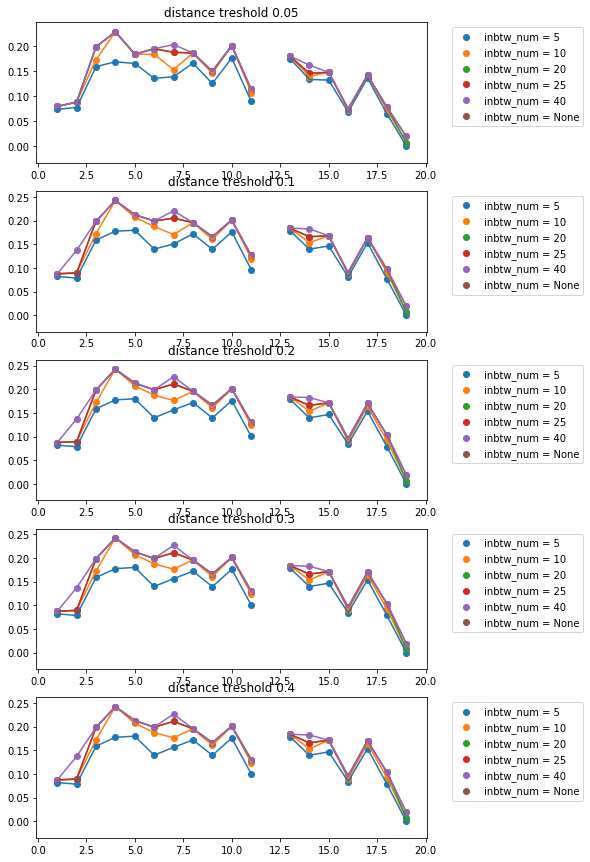

In [99]:
fig, ax = plt.subplots(len(distance_threshold), 1, figsize=(7, 15))
for i in range(len(distance_threshold)):
    dist = distance_threshold[i]
    current_summ = grid_search_summary[['CENSUS_WARD_NUM', dist, 'in_between_num']]
    for inbtw_num in in_between_num_list:
        current_summ_2 = current_summ.loc[current_summ['in_between_num'] == inbtw_num]
        ax[i].scatter(current_summ_2['CENSUS_WARD_NUM'], current_summ_2[dist], 
                      label = f'inbtw_num = {inbtw_num}')
        ax[i].plot(current_summ_2['CENSUS_WARD_NUM'], current_summ_2[dist])
    ax[i].set_title(f'distance treshold {dist}')
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

* once the number between two known dwellings is over 5, there is not much difference in how much we can interpolate.
* if the threshold of 10 makes sense intuitively, **setting the number to 10 is recommended**, as the interpolation does not improve much and the smaller the threshold, the less likely mis-interpolation

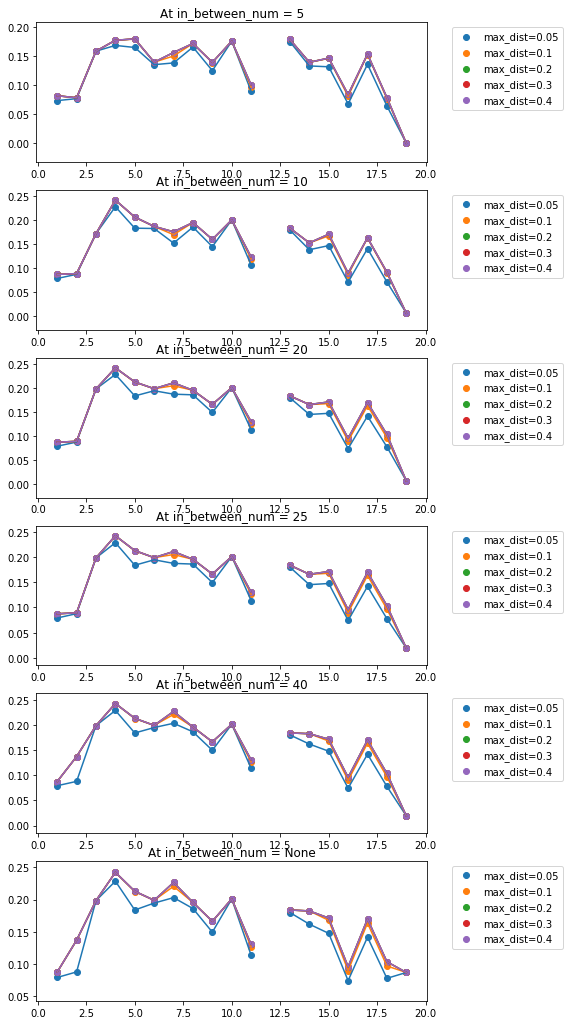

In [93]:
fig, ax = plt.subplots(len(in_between_num_list), 1, figsize=(7, 18))
for i in range(len(in_between_num_list)):
    current_summary = marginal_proportion_inbetween[i]
    for max_dist in distance_threshold:
        ax[i].scatter(current_summary['CENSUS_WARD_NUM'], current_summary[max_dist], 
                      label = f'max_dist={max_dist}')
        ax[i].plot(current_summary['CENSUS_WARD_NUM'], current_summary[max_dist])
    ax[i].set_title(f'in_between_num = {in_between_num_list[i]}')
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
 

* max_dist when generating distance sequence does not producing alarmingly different interpolation result, given in_between_num.
* Once the distance threshold is over 0.05 miles, the interpolation rate is not much different
* The value of the threshold can **solely depend on how we want the distance sequence to be**. Threshold = 0.25 generates the most even sequences (sequence length across the data).